In [6]:
!unzip archive.zip

# Data Set Source https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

Archive:  archive.zip
  inflating: fake_job_postings.csv   


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [2]:
orig_df = pd.read_csv('fake_job_postings.csv')

In [3]:
df = orig_df.copy()

In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df.pop("job_id")

0            1
1            2
2            3
3            4
4            5
         ...  
17875    17876
17876    17877
17877    17878
17878    17879
17879    17880
Name: job_id, Length: 17880, dtype: int64

In [6]:
df=df.fillna("N.A")

In [7]:
for i in df.columns:
  if df[i].isna().values.any():
    print(i,df[i].isna().values.any())

In [8]:
cat_cols,num_cols = df.describe(include='O').columns,df.describe().columns
cat_cols,num_cols

(Index(['title', 'location', 'department', 'salary_range', 'company_profile',
        'description', 'requirements', 'benefits', 'employment_type',
        'required_experience', 'required_education', 'industry', 'function'],
       dtype='object'),
 Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent'], dtype='object'))

In [9]:
for i in cat_cols:
    df[i].str.replace(' ','')
    df[i] = df[i].astype(str)

    if df[i].isna().values.any():
      print(i,df[i].isna().values.any())

In [10]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [11]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
df_train.size,df_val.size,df_test.size

df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

y_train=df_train['fraudulent']
y_val=df_val['fraudulent']
v_test=df_test['fraudulent']

df_train.pop('fraudulent')
df_val.pop('fraudulent')
df_test.pop('fraudulent')

0       0
1       0
2       0
3       0
4       0
       ..
3571    0
3572    0
3573    0
3574    0
3575    0
Name: fraudulent, Length: 3576, dtype: int64

In [12]:
inputs = {}

for name, column in df_train.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'title': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'title')>,
 'location': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'location')>,
 'department': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'department')>,
 'salary_range': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'salary_range')>,
 'company_profile': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'company_profile')>,
 'description': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'description')>,
 'requirements': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'requirements')>,
 'benefits': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'benefits')>,
 'telecommuting': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'telecommuting')>,
 'has_company_logo': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'has_company_logo')>,
 'has_questions': <KerasTensor: shape=(None, 1) dtype=floa

In [13]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(df_train[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

In [14]:
preprocessed_inputs = [all_numeric_inputs]
preprocessed_inputs

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization')>]

#One Hot Encoding

In [15]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  print(name)
  lookup = layers.StringLookup(vocabulary=np.unique(df_train[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

title
location
department
salary_range
company_profile
description
requirements
benefits
employment_type
required_experience
required_education
industry
function


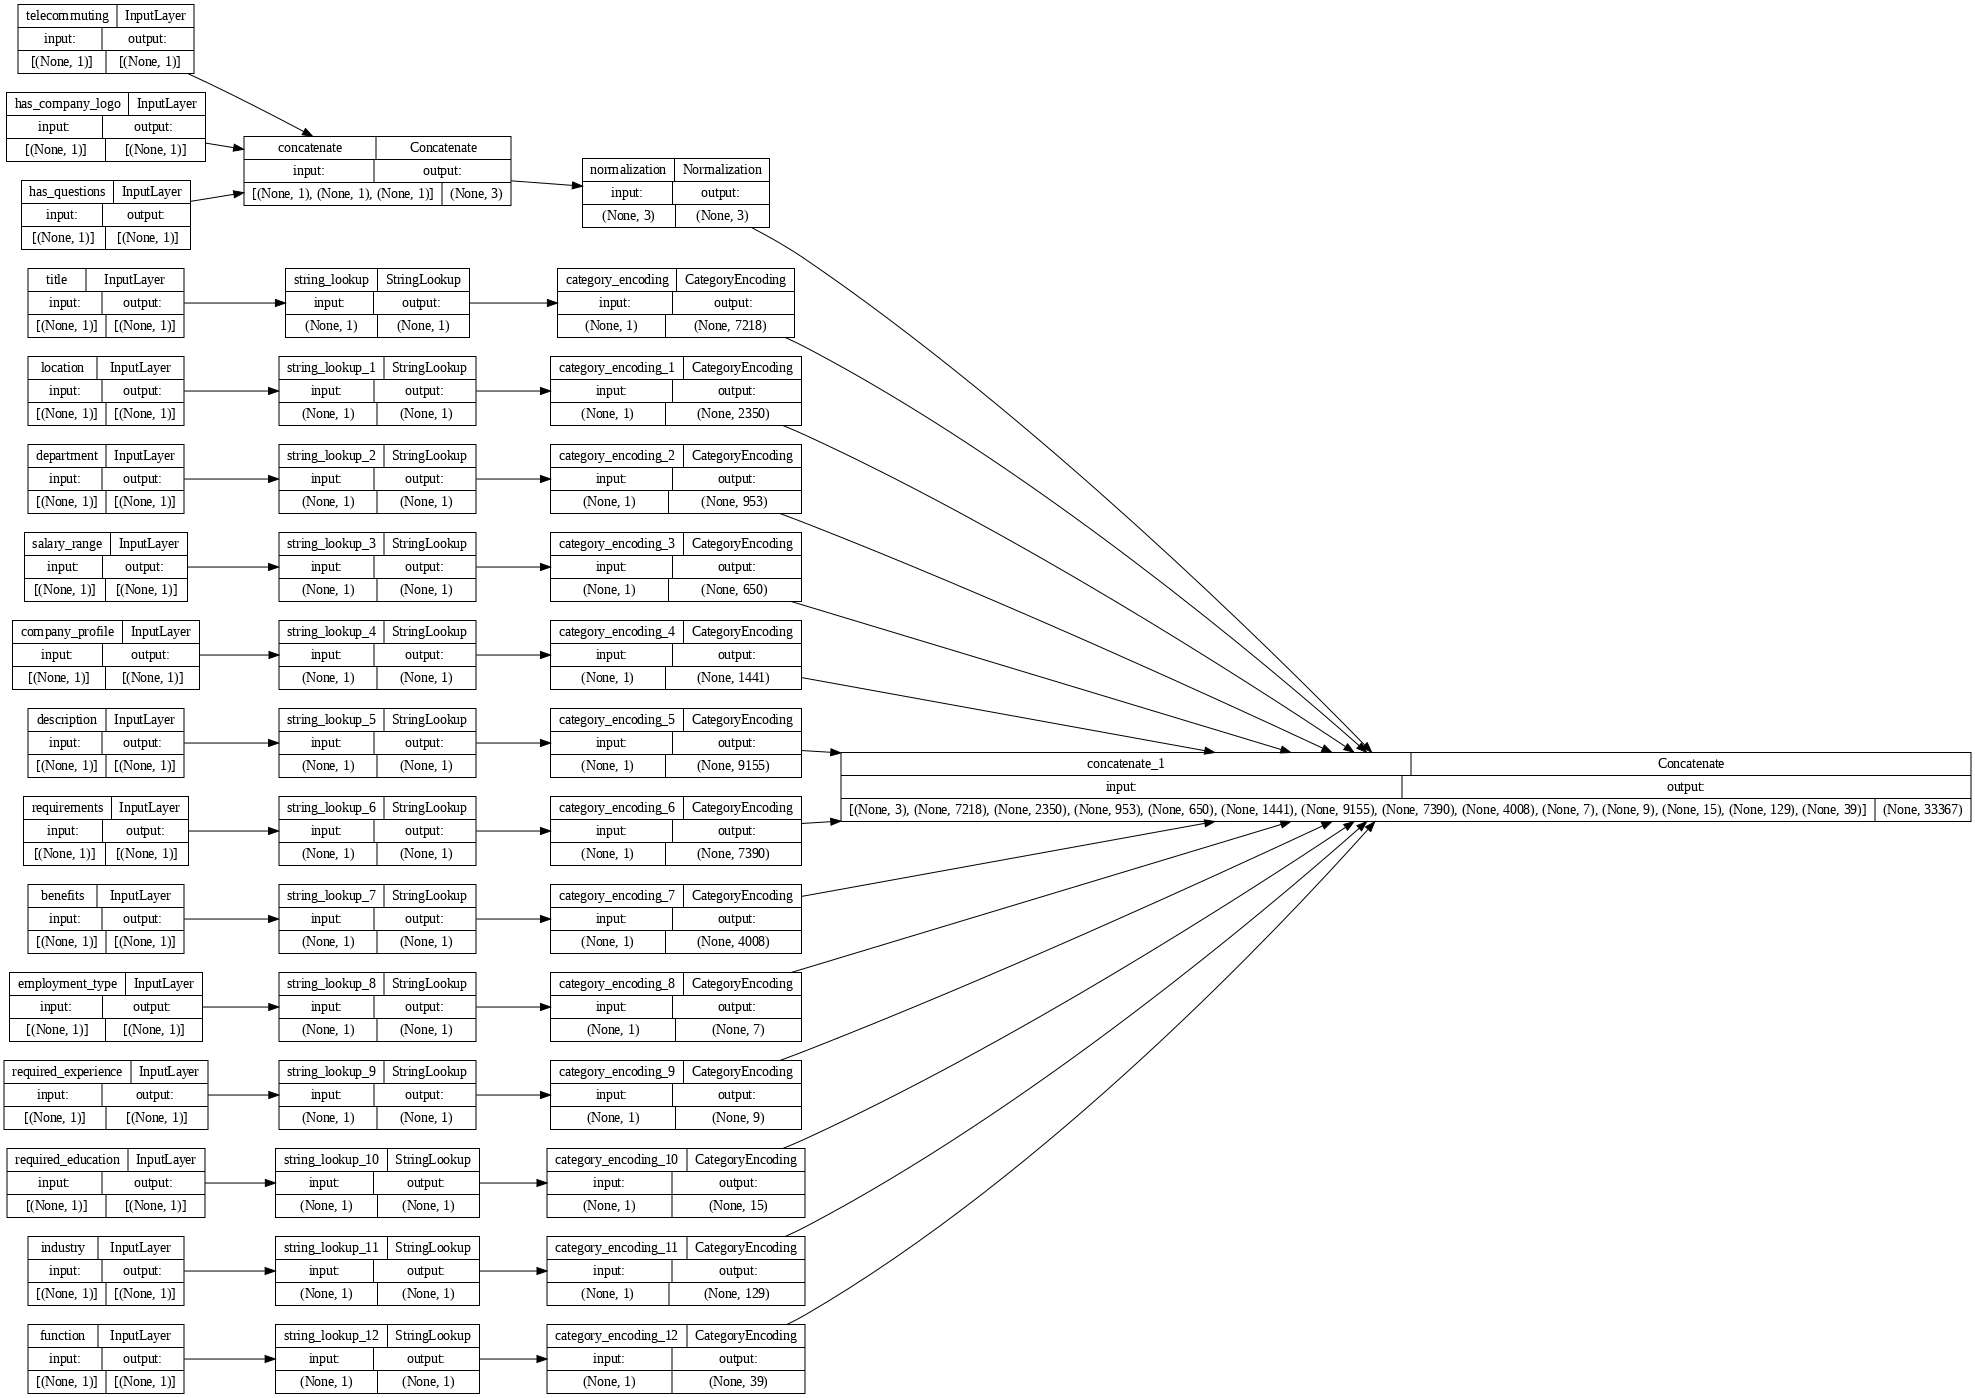

In [16]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

X_train_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = X_train_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [17]:
X_train = {name: np.array(value)
                         for name, value in df_train.items()}

X_val = {name: np.array(value)
                         for name, value in df_val.items()}

In [18]:
features_dict = {name:values[:1] for name, values in X_train.items()}
X_train_preprocessing(features_dict)

<tf.Tensor: shape=(1, 33367), dtype=float32, numpy=
array([[-0.21165866,  0.5119743 , -0.9896137 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

# Construct Dense Layer

In [19]:
def make_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1,activation='sigmoid')

  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),metrics=['acc'])
  return model

fraud_job_posting_model = make_model(X_train_preprocessing, inputs)

In [20]:
history=fraud_job_posting_model.fit(x=X_train, y=y_train, epochs=10,validation_data=(X_val,y_val))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


336/336 [==============================] - 7s 14ms/step - loss: 0.1332 - acc: 0.9590 - val_loss: 0.0766 - val_acc: 0.9743
Epoch 2/10
336/336 [==============================] - 5s 15ms/step - loss: 0.0351 - acc: 0.9880 - val_loss: 0.0541 - val_acc: 0.9835
Epoch 3/10
336/336 [==============================] - 4s 12ms/step - loss: 0.0078 - acc: 0.9991 - val_loss: 0.0497 - val_acc: 0.9832
Epoch 4/10
336/336 [==============================] - 4s 12ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9821
Epoch 5/10
336/336 [==============================] - 5s 16ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9829
Epoch 6/10
336/336 [==============================] - 4s 12ms/step - loss: 7.2516e-04 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9832
Epoch 7/10
336/336 [==============================] - 4s 13ms/step - loss: 4.7415e-04 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9829
Epoch 8/10
336/336 [==============================] - 5s 14ms/step - los

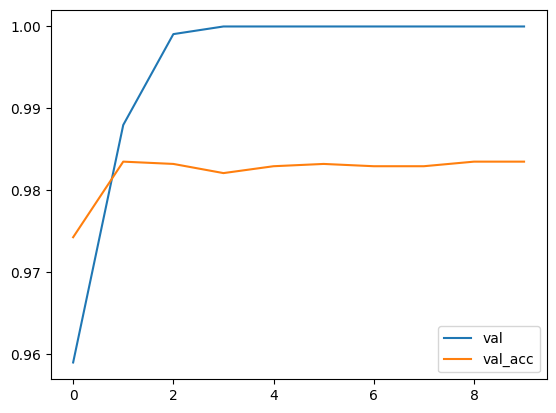

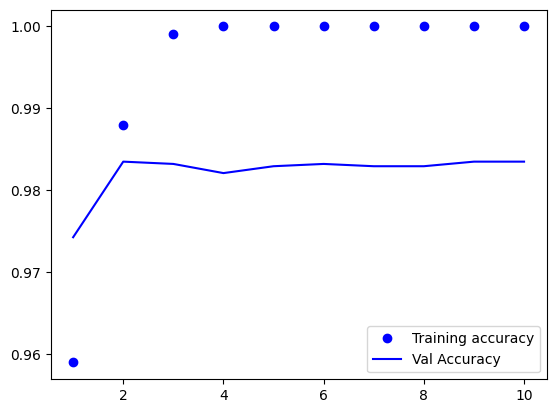

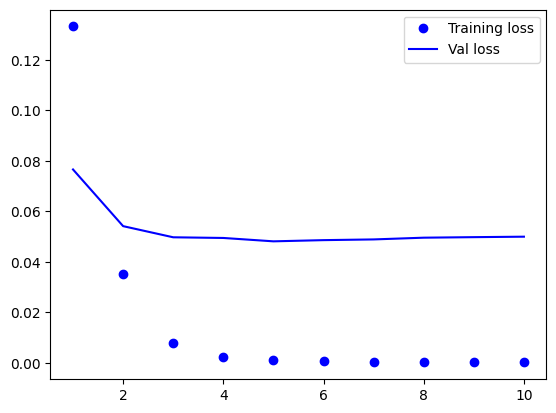

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(acc,label='val')
plt.plot(val_acc,label='val_acc')
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Val Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Val loss")
plt.legend()

# Testing Model

In [22]:
fraud_job_posting_model.save('test_model')
reloaded = tf.keras.models.load_model('test_model')




In [23]:
X_test = {name: np.array(value)
                         for name, value in df_test.items()}

results = reloaded.evaluate(X_test, v_test, batch_size=128)

predictions = reloaded.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


112/112 [==============================] - 1s 7ms/step


In [35]:
result = np.round(predictions,decimals=3)
pd.DataFrame(result)

,0
0,0.000
1,0.000
2,0.019
3,0.022
4,0.000
...,...
3571,0.000
3572,0.000
3573,0.001
3574,0.003


In [58]:
df_test.iloc[3100]

title                                       Cruise Staff Wanted *URGENT*
location                                                  US, TX, DALLAS
department                                                           N.A
salary_range                                                         N.A
company_profile                                                      N.A
description            6* Ultra Luxury American Cruise Company is urg...
requirements           Certification &amp; Experience: Previous exper...
benefits               Benefits: On board en suite accommodation and ...
telecommuting                                                          0
has_company_logo                                                       0
has_questions                                                          1
employment_type                                                      N.A
required_experience                                                  N.A
required_education                                 

In [57]:
result[3100],v_test[3100]

(array([1.], dtype=float32), 1)

In [51]:
np.where(result == 1)

(array([  75,  104,  202,  261,  569,  575,  767,  891, 1118, 1370, 1374,
        1568, 1721, 1785, 1833, 1914, 1993, 2208, 2308, 2393, 2529, 2572,
        2905, 3029, 3083, 3100, 3436, 3561]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))